In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.__version__

'2.2.3'

In [3]:
!pip install pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
url1="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet"

In [5]:
url2="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet"

In [6]:
df=pd.read_parquet(url1)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [7]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48326 non-null  int32         
 1   lpep_pickup_datetime   48326 non-null  datetime64[us]
 2   lpep_dropoff_datetime  48326 non-null  datetime64[us]
 3   store_and_fwd_flag     46490 non-null  object        
 4   RatecodeID             46490 non-null  float64       
 5   PULocationID           48326 non-null  int32         
 6   DOLocationID           48326 non-null  int32         
 7   passenger_count        46490 non-null  float64       
 8   trip_distance          48326 non-null  float64       
 9   fare_amount            48326 non-null  float64       
 10  extra                  48326 non-null  float64       
 11  mta_tax                48326 non-null  float64       
 12  tip_amount             48326 non-null  float64       
 13  t

In [9]:
def wrangle(filepath):
    df=pd.read_parquet(filepath)
    df["lpep_pickup_datetime"]=pd.to_datetime(df["lpep_pickup_datetime"])
    df["lpep_dropoff_datetime"]=pd.to_datetime(df["lpep_dropoff_datetime"])
    df["duration"]=df["lpep_dropoff_datetime"]-df["lpep_pickup_datetime"]
    df.duration=df.duration.apply(lambda td:td.total_seconds()/60)
    df=df[((df.duration>=1) & (df.duration<=60))]
    categorical=["PULocationID","DOLocationID"]
    #numerical=["trip_distance"]
    df[categorical]= df[categorical].astype(str)
    
    return df
    
        

In [10]:
df_train=wrangle(url1)
df_val=wrangle(url2)

In [11]:
df_train.tail()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.0
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.0
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.0
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.0
48325,2,2025-01-31 22:15:00,2025-01-31 22:22:00,None,NaN,42,194,NaN,1.37,66.67,...,10.00,6.94,NaN,1.0,85.11,NaN,NaN,NaN,NaN,7.0


In [12]:
df_train.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333


<Figure size 800x400 with 0 Axes>

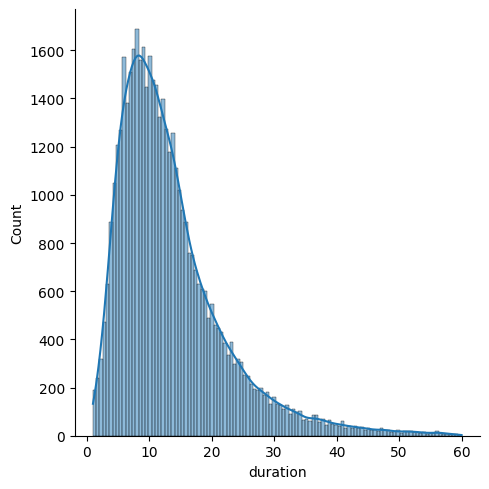

In [13]:
plt.figure(figsize=(8,4))
sns.displot(df_train.duration, kde=True);

In [14]:
df_train.duration.describe(percentiles=[0.5,0.6,0.7,0.8,0.95, 0.98, 0.99])

count    46307.000000
mean        13.493045
std          8.627705
min          1.000000
50%         11.450000
60%         13.283333
70%         15.500000
80%         18.833333
95%         30.600000
98%         38.981333
99%         44.916667
max         60.000000
Name: duration, dtype: float64

In [15]:
numerical=["trip_distance"]
categorical=["PULocationID","DOLocationID"]

train_dicts=df_train[categorical + numerical].to_dict(orient="records")
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)


val_dicts=df_val[categorical + numerical].to_dict(orient="records")
X_val=dv.transform(val_dicts)

In [16]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 138921 stored elements and shape (46307, 449)>

In [17]:
# dv.feature_names_

In [18]:
target="duration"
y_train=df_train[target].values

y_val=df_val[target].values

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
model=LinearRegression()

In [21]:
model.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred=model.predict(X_val)

/tmp/ipykernel_57751/2601734051.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="predictions")
/tmp/ipykernel_57751/2601734051.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="original")


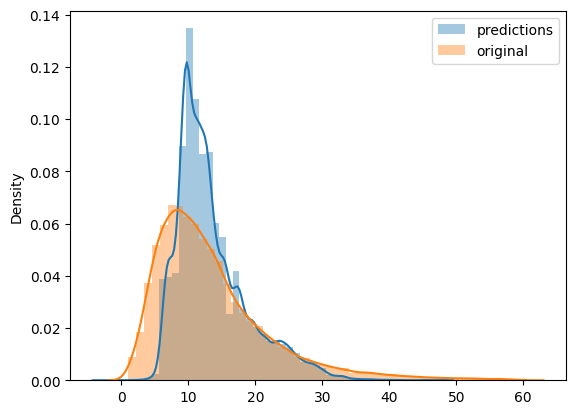

In [23]:
sns.distplot(y_pred, label="predictions")
sns.distplot(y_train, label="original")
plt.legend()

In [25]:
mean_squared_error(y_val, y_pred)

52.673907381651276

In [26]:
(np.sqrt(np.mean(np.square(y_val -  y_pred)))) #rmse

np.float64(7.257679200794926)

In [30]:
model1=Lasso(alpha=0.01)
model1.fit(X_train, y_train)
y_pred1=model1.predict(X_val)

/tmp/ipykernel_57751/2523177573.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred1, label="predictions")
/tmp/ipykernel_57751/2523177573.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="original")


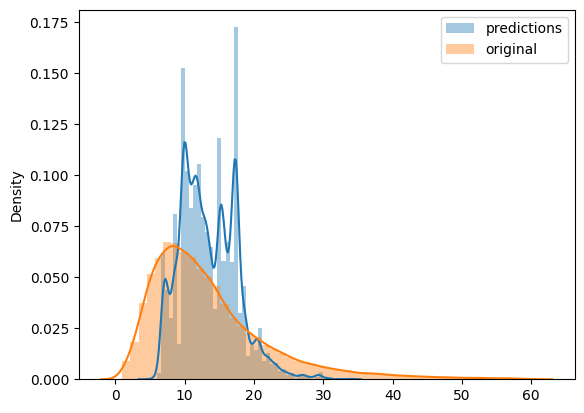

In [31]:
sns.distplot(y_pred1, label="predictions")
sns.distplot(y_train, label="original")
plt.legend()

In [32]:
mean_squared_error(y_val, y_pred1)

58.5936270548088

In [33]:
import pickle

In [34]:
with open ('models/lin_reg.bin' , 'wb') as f_out:
    pickle.dump((dv, model), f_out)